In [10]:
import os
import cv2
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
image_directory = 'chest/train/'
dataset = []
labels = []

In [12]:
normal_scan=os.listdir(image_directory+'NORMAL/')

In [13]:
for i,image_name in enumerate(normal_scan):
    image = cv2.imread(image_directory +'NORMAL/'+image_name)
    image = Image.fromarray(image , 'RGB')
    image = image.resize((300,300))
    dataset.append(np.array(image))
    labels.append(0)

In [14]:
pneumonia_scan=os.listdir(image_directory+'PNEUMONIA/')
for i,image_name in enumerate(pneumonia_scan):
    image = cv2.imread(image_directory +'PNEUMONIA/'+image_name)
    image = Image.fromarray(image , 'RGB')
    image = image.resize((300,300))
    dataset.append(np.array(image))
    labels.append(1)

In [15]:
dataset = np.array(dataset)
labels = np.array(labels)
dataset.shape
labels.shape

(2682,)

In [16]:
dataset= dataset/255
type(dataset)

numpy.ndarray

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train,X_test,Y_train,Y_test = train_test_split(dataset,labels,test_size =0.2 , random_state=42 ,shuffle=True)

In [19]:
print(Y_train.size)
print(Y_test.size)

2145
537


In [11]:

model= Sequential()
model.add(Conv2D(64,(3,3), input_shape=(300,300,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3), kernel_initializer="he_uniform"))
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3) , kernel_initializer="he_uniform"))
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation("sigmoid"))

In [12]:
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 activation (Activation)     (None, 298, 298, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      18464     
                                                                 
 activation_1 (Activation)   (None, 147, 147, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                   

In [14]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=64,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test,Y_test),
                    shuffle=True
                   )

Epoch 1/50
34/34 [==============================] - 191s 6s/step - loss: 0.7304 - accuracy: 0.5413 - val_loss: 0.6471 - val_accuracy: 0.4935
Epoch 2/50
34/34 [==============================] - 178s 5s/step - loss: 0.6051 - accuracy: 0.6900 - val_loss: 0.4961 - val_accuracy: 0.8976
Epoch 3/50
34/34 [==============================] - 171s 5s/step - loss: 0.5246 - accuracy: 0.7939 - val_loss: 0.4365 - val_accuracy: 0.9032
Epoch 4/50
34/34 [==============================] - 171s 5s/step - loss: 0.4975 - accuracy: 0.8145 - val_loss: 0.4671 - val_accuracy: 0.7970
Epoch 5/50
34/34 [==============================] - 169s 5s/step - loss: 0.4969 - accuracy: 0.8042 - val_loss: 0.4227 - val_accuracy: 0.8771
Epoch 6/50
34/34 [==============================] - 168s 5s/step - loss: 0.4772 - accuracy: 0.8242 - val_loss: 0.4042 - val_accuracy: 0.9255
Epoch 7/50
34/34 [==============================] - 169s 5s/step - loss: 0.4459 - accuracy: 0.8452 - val_loss: 0.4157 - val_accuracy: 0.9274
Epoch 8/50
34

In [15]:
tf.keras.models.save_model(
    model,
    "CNN_bal.model",
    overwrite=True,
    include_optimizer=True
) 

INFO:tensorflow:Assets written to: CNN_bal.model\assets


INFO:tensorflow:Assets written to: CNN_bal.model\assets


In [20]:
from tensorflow.keras.models import load_model
resnet_bal = load_model("resnet_b_model.model")

In [21]:
from tensorflow.keras.models import load_model
CNN_model = load_model("CNN_bal.model")

In [22]:
CNN_model.evaluate(X_test,Y_test)

17/17 [==============================] - 10s 560ms/step - loss: 0.1306 - accuracy: 0.9683


[0.13062962889671326, 0.968342661857605]

In [23]:
test_values1 = CNN_model.predict(X_test)
y_preds1 = test_values1.ravel()

17/17 [==============================] - 8s 447ms/step


In [24]:
test_values2 = resnet_bal.predict(X_test)
y_preds2 = test_values2.ravel()

17/17 [==============================] - 48s 3s/step


In [25]:
from sklearn.metrics import confusion_matrix
y_preds1 = (test_values1>= 0.5).astype(int)
cm=confusion_matrix(Y_test,y_preds1)
print(cm)

[[258   7]
 [ 10 262]]


In [26]:
y_preds1 = test_values1.ravel()

<function matplotlib.pyplot.show(close=None, block=None)>

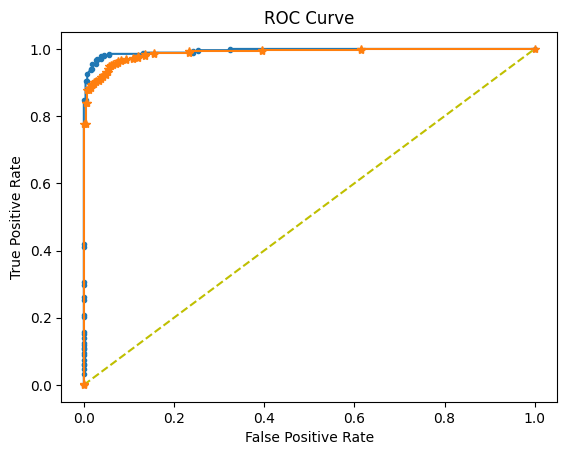

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve
fpr1,tpr1,thresholds1 = roc_curve(Y_test,y_preds1)
fpr2,tpr2,thresholds2 = roc_curve(Y_test,y_preds2)
plt.figure(2)
plt.plot([0,1],[0,1],'y--')
plt.plot(fpr1,tpr1,marker='.')
plt.plot(fpr2,tpr2,marker='*')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show

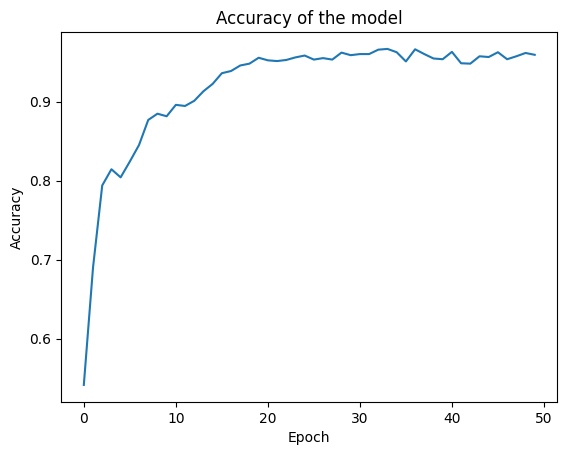

In [24]:
plt.plot(model.history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of the model')
plt.show()

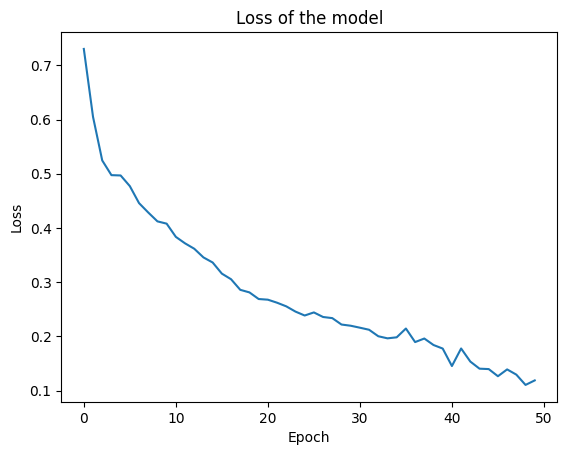

In [25]:
plt.plot(model.history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of the model')
plt.show()

In [27]:
tests=[]
sample=os.listdir('pam/')
for i,image_name in enumerate(sample):
    image = cv2.imread('pam/'+image_name)
    image = Image.fromarray(image , 'RGB')
    image = image.resize((300,300))
    tests.append(np.array(image))
tests=np.array(tests)

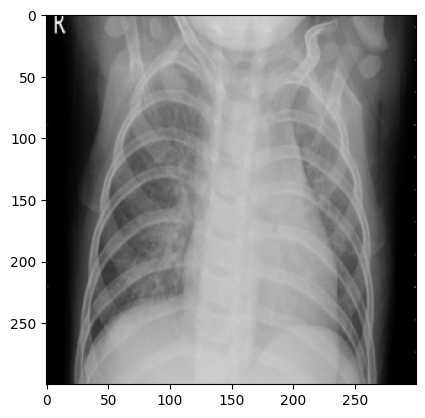

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image)

In [29]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 activation (Activation)     (None, 298, 298, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      18464     
                                                                 
 activation_1 (Activation)   (None, 147, 147, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                   

In [30]:
difference= []

In [31]:
for i,j in enumerate(Y_test):
    difference.append((j-y_preds1[i])**2)

In [32]:
diff = np.array(difference)

In [33]:
mse = diff.mean()

In [34]:
import math
rmse = math.sqrt(mse)

In [35]:
print("root mean square error = ",rmse)
print("mean square error =",mse)

root mean square error =  0.15616943805591527
mean square error = 0.024388893382700356
